In [1]:
#Full Name : Dahani Zakaria
#MSc Big Data Ensai

In [2]:
import pandas as pd
import sys; sys.path.append('/home/zakaria/.local/lib/python2.7/site-packages')
import nltk 
from IPython.display import Image

In [3]:
df_train = pd.read_csv("train_v2.csv",sep=";")
df_test = pd.read_csv("test_v2.csv",sep=";")


In [4]:
#"Id","Title","FullDescription","LocationNormalized","ContractType","ContractTime","Company",
#"Category","SourceName"

# Text Mining

In [5]:
df_train_selection = pd.DataFrame(data=df_train,columns=['LocationNormalized','ContractType', 'ContractTime',
                                                         'Company','Category','SourceName'])

df_test_selection = pd.DataFrame(data=df_test,columns=['LocationNormalized','ContractType', 'ContractTime',
                                                         'Company','Category','SourceName'])


df_train_title_fullD = pd.DataFrame(data=df_train,columns=['Title','FullDescription'])
df_test_title_fullD = pd.DataFrame(data=df_test,columns=['Title','FullDescription'])

# We merge de train and test selection to have the same number of fields after dummification nd vectorization
df_selection = pd.concat([df_train_selection,df_test_selection], axis=0)
df_title_fullD = pd.concat([df_train_title_fullD,df_test_title_fullD], axis=0)


In [6]:
## Dummification of the selected columns

df_dummy = pd.get_dummies(df_selection, prefix=['LocationNormalized','ContractType', 'ContractTime',
                                                            'Company','Category','SourceName'])


In [7]:
## We add the dummified columns to the df_title_fullD data frame

df_final = pd.concat([df_title_fullD,df_dummy], axis=1)


##### 1. FullDescription Processing 

In [8]:
#Installing NLTK Data

from nltk.corpus import stopwords
nltk.download()
# We Click at Download in the pop up panel 

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [9]:
stop = set(stopwords.words('english'))

In [10]:
## We remove punctuation 
stop.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}'])

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import CountVectorizer

In [12]:
vectorizer = TfidfVectorizer(min_df=1,stop_words=stop)

In [13]:
df_final['FullDescription'] = df_final['FullDescription'].astype(str)#We Convert the Totle Column to String 
                                                                     #Otherwise it will give an error : 
                                                                     #'float' object has no attribute 'decode'
        
#We remove unicode characters from the FullDescription filed
df_final['FullDescription'] = df_final['FullDescription'].apply(lambda x: x.decode('unicode_escape').
                                                                encode('ascii', 'ignore').strip())

In [14]:
#features extraction

#We Convert the FullDescription field to a matrix of TF-IDF features.
#Equivalent to CountVectorizer followed by TfidfTransformer.

#The vocabulary argument
corpus_fullD=df_final['FullDescription']

#We fit (caluculate counts) with the given corpus_fullD 
vectorizer_fullD = vectorizer.fit_transform(corpus_fullD)
### Feature  names
feature_fullD=pd.DataFrame(vectorizer.get_feature_names())
#tf idf values
tf_idf_fullD=pd.DataFrame(vectorizer_fullD.toarray())
#We combine the 2
result_fullD=pd.DataFrame(tf_idf_fullD.values,columns= (feature_fullD.iloc[:,0]).tolist())


In [15]:
## We drop the original columns from the main dataframe 

df_final=df_final.drop('FullDescription',axis=1)


In [16]:
#We add tf idf of column "Full Description" to the df_final

#pd.concat requires that the indices be unique
df_final = df_final.loc[~df_final.index.duplicated(keep='first')]
result_fullD = result_fullD.loc[~result_fullD.index.duplicated(keep='first')]


df_final=pd.concat([df_final,result_fullD],axis=1)

##### 2. Title processing

In [17]:
##We create the vectorizer

ngram_vectorizer = TfidfVectorizer(ngram_range=(1,2),token_pattern=r'\b\w+\b',
                                    min_df=1,stop_words=stop)


In [18]:
df_final['Title'] = df_final['Title'].astype(str)#We Convert the Totle Column to String 
                                                 #Otherwise it will give an error : 
                                                 #'float' object has no attribute 'decode'

df_final['Title']=df_final['Title'].apply(lambda x: x.decode('unicode_escape').encode('ascii', 'ignore').strip())



/home/zakaria/.local/lib/python2.7/site-packages/pandas/indexes/base.py:1396: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


In [19]:
#features extraction

corpus_title=df_final['Title']
vectorizer_title = ngram_vectorizer.fit_transform(corpus_title)
feature_title=pd.DataFrame(ngram_vectorizer.get_feature_names())
tf_idf_title=pd.DataFrame(vectorizer_title.toarray())
result_title=pd.DataFrame(tf_idf_title.values,columns= (feature_title.iloc[:,0]).tolist())

In [20]:
df_final=df_final.drop('Title',axis=1)

/home/zakaria/.local/lib/python2.7/site-packages/pandas/indexes/base.py:2286: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)


In [21]:
df_final=pd.concat([df_final,result_title],axis=1)

In [22]:
train_length = len(df_train)
test_length = len(df_test)

In [23]:
#We split the processed data (train & test) and return it to its original frame: 
#train_data and test_data using the length of the original frame df_train and df_test
#to extract to corresponding data

In [24]:
train_data = df_final[0:train_length]

In [25]:
train_data = pd.concat([df_train['SalaryNormalized'],train_data],axis=1)

In [26]:
test_data = df_final[-test_length:]

# Model Training

In [27]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [28]:
y_train = train_data['SalaryNormalized']
x_train = train_data.drop('SalaryNormalized',axis=1)

In [29]:
#We replace de NaN values with 0 to not get an error during the test
test_data = test_data.fillna(0)

#### <font color='cyon'>K Nearest Neighbors</font> 

In [49]:
#knr_model = KNeighborsRegressor(n_neighbors=2) # It took too much time !!!

In [50]:
#knr_model.fit(x_train, y_train)

In [51]:
#knr_salary_prediction = knr_model.predict(test_data)

In [52]:
#df_test['PredictedSalary'] = knr_salary_prediction

In [53]:
#knr_df_submit = pd.DataFrame(data=df_test,columns=['Id','PredictedSalary'])

In [54]:
#knr_df_submit.to_csv("/home/zakaria/Desktop/knr_submit.csv",index=False)

In [55]:
#Image(filename='/home/zakaria/Desktop/knr.png') 

#### <font color='cyon'>Random Forest</font> 

In [30]:
rf_model = RandomForestRegressor()

In [31]:
# Train the model using the training set
rf_model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [34]:
rf_salary_prediction = rf_model.predict(test_data)

In [35]:
df_test['PredictedSalary'] = rf_salary_prediction

In [36]:
rf_df_submit = pd.DataFrame(data=df_test,columns=['Id','PredictedSalary'])

In [38]:
rf_df_submit.to_csv("/home/zakaria/Desktop/rf_submit.csv",index=False)

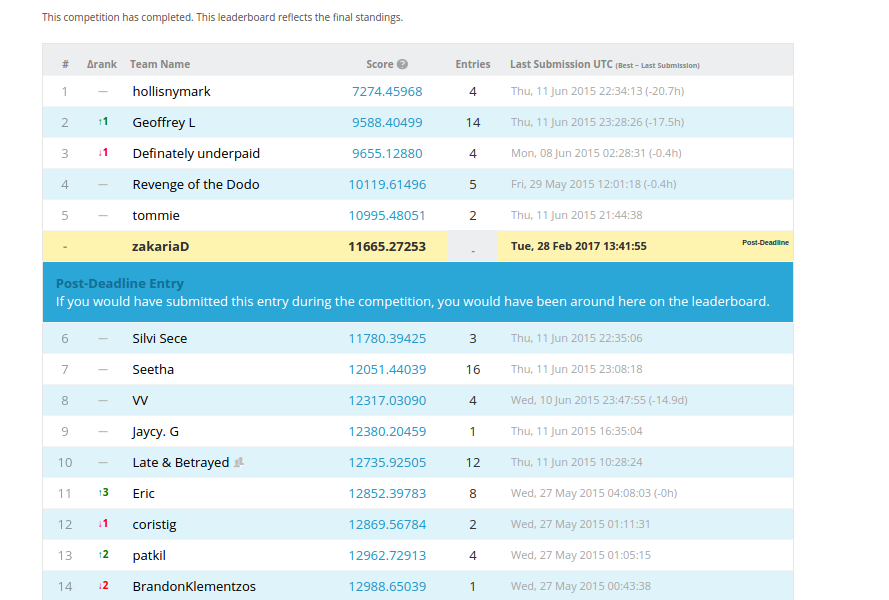

In [47]:
Image(filename='/home/zakaria/Desktop/rf.png') 

### Kaggle Score for the random Forest model is : <font color='red'>11665.27253</font> 

#### <font color='cyon'>Decision Tree</font> 

In [32]:
dt_model = DecisionTreeRegressor(random_state=0)

In [33]:
# Train the model using the training set
dt_model.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')

In [43]:
dt_salary_prediction = dt_model.predict(test_data)

In [44]:
df_test['PredictedSalary'] = dt_salary_prediction

In [45]:
dt_df_submit = pd.DataFrame(data=df_test,columns=['Id','PredictedSalary'])

In [46]:
dt_df_submit.to_csv("/home/zakaria/Desktop/dt_submit.csv",index=False)

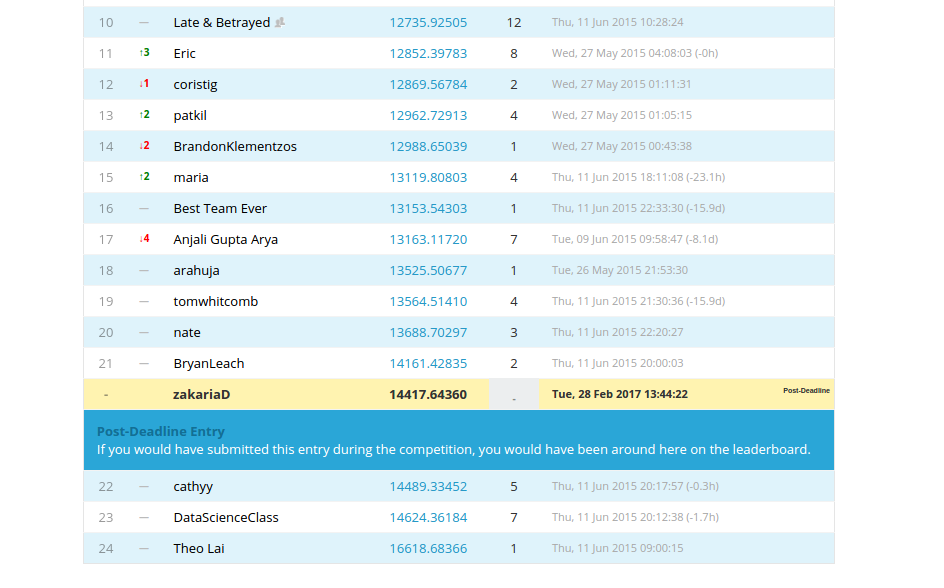

In [48]:
Image(filename='/home/zakaria/Desktop/dt.png') 

### Kaggle Score for the Decision Tree model is : <font color='red'>14417.64360</font>  